# Estudos ML - Aplicação para Pricing

In [1]:
## importando as bibliotecas

import pandas as pd
import numpy as np

##  importando bibiliotecas de ml

from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV
                                    )
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## carregando datasets

order_itens = pd.read_csv('olist_order_items_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

## fazendo merge

df = order_itens.merge(order, on='order_id') \
                .merge(order_payments, on=['order_id']) \
                .merge(products, on='product_id') \
                .merge(customers, on='customer_id') \
                .merge(sellers, on='seller_id') \
                .merge(translation, on='product_category_name')

df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,9.0,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,27277,volta redonda,SP,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,9.0,14.0,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,27277,volta redonda,SP,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,...,9.0,14.0,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,27277,volta redonda,SP,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,...,9.0,14.0,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,27277,volta redonda,SP,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,...,9.0,14.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,27277,volta redonda,SP,cool_stuff


In [3]:
## número de linhas e colunas

df.shape

(115878, 34)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115878 non-null  object 
 1   order_item_id                  115878 non-null  int64  
 2   product_id                     115878 non-null  object 
 3   seller_id                      115878 non-null  object 
 4   shipping_limit_date            115878 non-null  object 
 5   price                          115878 non-null  float64
 6   freight_value                  115878 non-null  float64
 7   customer_id                    115878 non-null  object 
 8   order_status                   115878 non-null  object 
 9   order_purchase_timestamp       115878 non-null  object 
 10  order_approved_at              115864 non-null  object 
 11  order_delivered_carrier_date   114673 non-null  object 
 12  order_delivered_customer_date 

In [5]:
## excluir info irrelevantes

df = df.drop(['seller_id', 'freight_value'], axis=1)

Frete foi desconsiderado pois precisa de mais estudos se ele têm ou não impacto na decisão de consumo de um produto.

In [6]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')

In [7]:
## colunas que importam na precificação

df = df[['product_category_name', 
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty',
   'product_weight_g',
   'product_length_cm',
   'product_height_cm',
   'product_width_cm',
   'price']]

## excluindo desde já os missings

df = df.dropna()

df.shape

(115877, 9)

### Outliers

- Devemos retirar ou não eles?

<Axes: ylabel='price'>

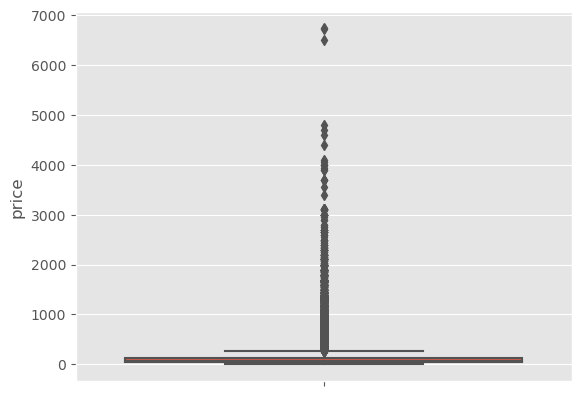

In [8]:
## checando os outliers

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

sns.boxplot(y='price', data =df)

<Axes: ylabel='product_weight_g'>

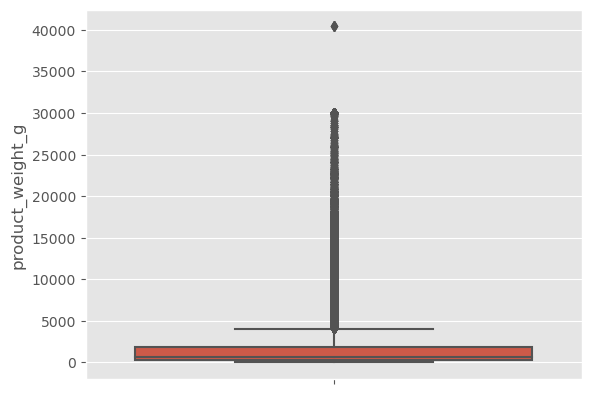

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

sns.boxplot(y='product_weight_g', data =df)

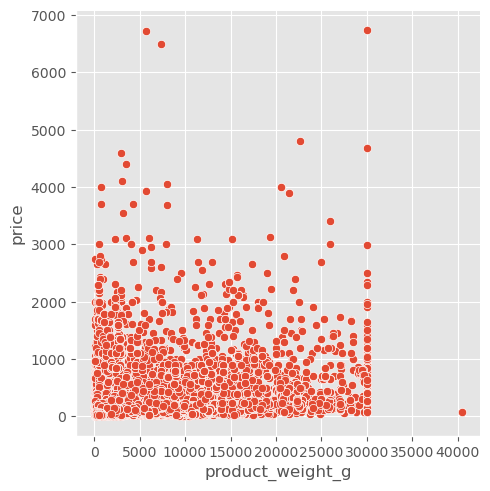

In [10]:
## checando se há correlação entre preço e peso

sns.relplot(x='product_weight_g', y='price', data=df)

In [11]:
## checando correlação

df.corr()

C:\Users\pasch\AppData\Local\Temp\ipykernel_2324\1310561345.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price
product_name_lenght,1.000000,0.090322,0.145587,0.020871,0.058367,-0.030346,0.061983,0.017833
product_description_lenght,0.090322,1.000000,0.117016,0.063572,0.008129,0.073599,-0.067683,0.201752
product_photos_qty,0.145587,0.117016,1.000000,0.021481,0.045311,-0.033584,0.007539,0.052465
product_weight_g,0.020871,0.063572,0.021481,1.000000,0.462663,0.581458,0.506059,0.340328
product_length_cm,0.058367,0.008129,0.045311,0.462663,1.000000,0.190844,0.533445,0.145759
product_height_cm,-0.030346,0.073599,-0.033584,0.581458,0.190844,1.000000,0.278007,0.224375
product_width_cm,0.061983,-0.067683,0.007539,0.506059,0.533445,0.278007,1.000000,0.172430
price,0.017833,0.201752,0.052465,0.340328,0.145759,0.224375,0.172430,1.000000


In [12]:
## uma forma de retirar os outliers - 5% acima e abaixo

outliers = df[(df['price']< df['price'].quantile(0.05)) | (df['price']> df['price'].quantile(0.95))]

outliers.shape[0]/df.shape[0]

0.09934672109219259

## Precificação com ML

In [13]:
#checando as colunas

df.columns

Index(['product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'price'],
      dtype='object')

In [14]:
df.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price
count,115877.000000,115877.000000,115877.000000,115877.000000,115877.000000,115877.000000,115877.000000,115877.000000
mean,48.766019,786.955755,2.207720,2117.594190,30.311554,16.656886,23.110445,120.909070
std,10.035355,653.074676,1.719525,3785.744297,16.225837,13.480721,11.758209,184.140924
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.850000
25%,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000,39.900000
50%,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000,74.900000
75%,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,134.900000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,6735.000000


In [15]:
numerical = ['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm']

categorical = ['product_category_name']

In [16]:
features = ['product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm']

target = ['price']

In [17]:
X = df[features]

y = df[target]

In [18]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

# 1° Tentativa

In [19]:
## fazendo transformações nos dados - para variáveis contínuas e categóricas

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', TargetEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical),
    ('cat', categorical_transformer, categorical)
])

xgb = XGBRegressor()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['product_name_lenght',
                                                   'product_description_lenght',
                                                   'product_photos_qty',
                                                   'product_weight_g',
                                                   'product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['product_category_name'])]...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [20]:
y_pred = pipe.predict(X_test)

In [21]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred)**0.5}')

MAE: 45.27804033673053
MSE: 14252.017309517916
RMSE: 119.3818131438701


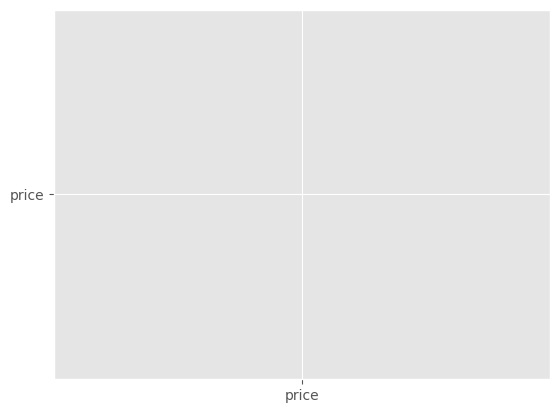

In [38]:
## verificando visualmente como estão as previsões de preços x preços reais

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', data=df)
plt.show()

## Fazendo Cross-Validation para evitar Overfiting

In [23]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores

array([-13234.01768398, -11145.93314362, -13996.01868388, -12253.11950909,
       -13320.97119338])

# 2° Tentativa

In [26]:
param_grid = {
    'model__learning_rate': np.linspace(start = 0.001, stop = 0.3, num = 10),
    'model__max_depth': [3, 5, 7, 10, 12, 15],
    'model__n_estimators': [100, 200, 300, 500, 1000]
}

random_search = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, cv = 5, n_iter =3)

random_search.fit(X_train, y_train)

print('Melhores hiperparâmetros: ', random_search.best_params_)

Melhores hiperparâmetros:  {'model__n_estimators': 1000, 'model__max_depth': 12, 'model__learning_rate': 0.1671111111111111}


# 3° Tentativa

In [28]:
## vamos criar ua nova coluna - feature e checar como ela se comporta - criando 'volume'

df['volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

df.head()

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,volume
0,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,58.9,3528.0
1,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,55.9,3528.0
2,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,64.9,3528.0
3,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,58.9,3528.0
4,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,58.9,3528.0


In [29]:
X_train['volume'] = X_train['product_length_cm'] * X_train['product_height_cm'] * X_train['product_width_cm']

X_test['volume'] = X_test['product_length_cm'] * X_test['product_height_cm'] * X_test['product_width_cm']

numerical.append('volume')

In [30]:
## fazendo tratamento de retirada de outliers

train = pd.concat([X_train, y_train], axis=1)

z_scores = np.abs((train['price'] - train['price'].mean())/train['price'].std())

outlier_threshold = 3

train_outliers = train[z_scores <= outlier_threshold]
train.shape, train_outliers.shape

((92701, 10), (91049, 10))

In [31]:
X_train.columns

Index(['product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume'],
      dtype='object')

In [32]:
X_train_wo_outliers = train_outliers[['product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume']]

y_train_wo_outliers = train_outliers[['price']]

In [33]:
## fazendo transformações nos dados - para variáveis contínuas e categóricas

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', TargetEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical),
    ('cat', categorical_transformer, categorical)
])

xgb = XGBRegressor()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

pipe.fit(X_train_wo_outliers, y_train_wo_outliers)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['product_name_lenght',
                                                   'product_description_lenght',
                                                   'product_photos_qty',
                                                   'product_weight_g',
                                                   'product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm',
                                                   'volume']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['product_category...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [35]:
y_pred = pipe.predict(X_test)

In [36]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred)**0.5}')

MAE: 46.13645183658282
MSE: 23263.03491364436
RMSE: 152.5222439962262


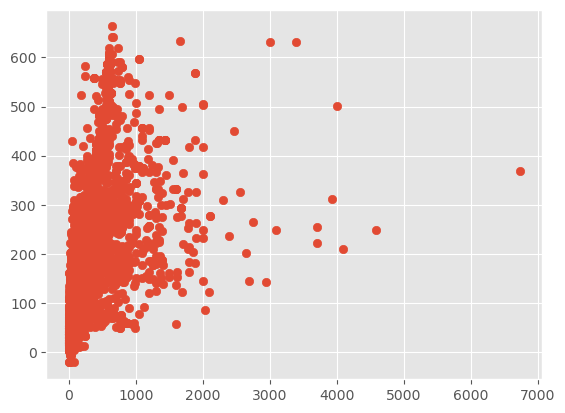

In [37]:
plt.scatter(y_test, y_pred)

Até o momento - o primeiro modelo foi o melhor

## Dicas Adicionais:

Além das melhorias dos modelos, podemos utilizar o conceito de elasticidade para aplicar junto ao modelo e encontrar o melhor preço - ponto ótimo - lucratividade e estratégia da empresa.

- Elasticidade do produto/serviço